# Motivation

**What is your dataset?**

Our dataset consists of two parts:
1. A list of all characters appearing in A Song of Ice and Fire, book 1-5, found here: http://awoiaf.westeros.org/index.php/List_of_characters
2. Transcript of all the Game of Thrones episodes found here: (Indsæt github link)

**Why did you choose these particular datasets?**

We chose these datasets because we find the Game of Thrones universe interesting, and would like to analyse different questions regarding that.
One of the most asked questions is: Who is the main character of Game of Thrones? And we feel that using network graphs could potentially provide an answer to that question.

**What was your goal for the end user's experience?**

Our goal is to provide the user an overview of the most important statistics regarding Game of Thrones, and using these to answer questions like, Who is the main character? Which Great House is the greatest?

# Basic stats.

**Write about your choices in data cleaning and preprocessing**

- For making the graph, the only cleaning made was to remove "[[" by regex, to make the name of the nodes more clean.
- For the transcripts we removed all special characters aswell as making the whole dataset lowercase. We also use the nltk package to remove stopwords, as it is just filler.

**Write a short section that discusses the dataset stats.**

- The graph has 2046 nodes and 9916 edges, and has 15 communities.
- The transcripts are from 7 different seasons, covering 67 episodes, each 17.500 words (After removing stopwords).

The graph that is larger than the philosophers network, and has a good size to perform data analysis on. The transcripts provide enough words, so that context can be extracted from the different great houses. 
The Lexical dispersion plots are also best when used on larger datasets.

# Imports

In [3]:
import sys
import os
import pickle
import re
import urllib2
import json
import time
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
import community
from cStringIO import StringIO
import pysrt
import glob
import nltk
#nltk.download()
#download the Punkt package

# Saving / Loading Data

> In the following part, we use these methods to save/load files. Typically only data which either takes a lot of time to compute or requires internet access is saved, such that re-running the entire notebook can be done without internet and fairly fast.

> Every file has a key defined, this makes sure no wrong strings are used. It also turn the the folder DATA into a of key-to-file mapping.

In [2]:
def saveFile(key, data):
    s = 'Data/%s.pkl' % key
    
    if not os.path.exists(os.path.dirname(s)):
        os.makedirs(os.path.dirname(s))
        
    with open(s, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
    print s, 'saved!'
        
def loadFile(key):
    s = 'Data/%s.pkl' % key
    try:
        with open(s, 'rb') as f:
            obj = pickle.load(f)
        print s, 'loaded!'
    except IOError, e:
        obj = None
        print s, 'not found!'
    return obj

class Keys:
    characterSetKey = 'characterSet'
    redirectDictionaryKey = 'redirectDictionary'
    neighboursDictionaryKey = 'neighboursDictionary'
    greatHousesDictionaryKey = 'greatHouseDictionary'
    pathDictionaryKey = 'pathDictionary'
    centralityDictionaryKey = 'centralityDictionary'

# Data Gathering

> We're interrested in collection data from 'http://awoiaf.westeros.org'. To be specific, we would like to collect a set of all characters, and for each character a set of characters that they link to. This data will be used to construct the graph. 

> This website supports the standard wiki-api, and because of that, we have constructed the getData function which constructs a UrlQuery and attemps to connect to and collect from the api up to 5 times. The format chosen is that of json, because it's easy to navigate in python. Some sites redirect to another site, and this is automatically handled as well. The method collects the inner text from each given link, and also the title of the character.

In [3]:
def getData(name, attempt=1):
    # Drop at 6th attempt
    if attempt > 5:
        return None, None
    
    # Query
    baseurl = "http://awoiaf.westeros.org/api.php?"
    action = 'action=query'
    content = 'prop=revisions&rvprop=content'
    dataformat = 'format=json'
    title = "titles=%s" % name.replace(' ','_') # Wiki link space format
    query = '%s&%s&%s&%s&%s' % (baseurl,action,title,content,dataformat)

    # Internet Connection
    try:
        # Posing as browser, since this wiki dislikes bots.
        request = urllib2.Request(query, None, {'User-Agent': 'Mozilla/5.0'})
        response = urllib2.urlopen(request, timeout=10)
        text = response.read()
    except:
        # Connection Errors => try again in a little while
        time.sleep(5) # 5 second(s)
        return getData(name, attempt+1)
    
    # Data
    try:
        jsonObj = json.loads(text)
    except:
        # Wrong format => drop it
        return None, None
    try:
        data = jsonObj['query']['pages'].values()[0]['revisions'][0]['*']
    except:
        # Wrong Data
        data = None
    try:
        name = jsonObj['query']['pages'].values()[0]['title']
    except:
        # Wrong Name
        name = None
    
    # Redirect
    if data:
        redirect = re.findall(r'^#REDIRECT \[\[(.*?)\]\]', data)
        if redirect:
            # Redirected url => try the redirect
            return getData(redirect[0], 1)
    
    # End goal
    return data, name

#### CharacterSet
> The getCharacterSet function extracts a set of names of the 'List of characters' subsite. Each character name's Url is then visited to get the unique title for each character. All these unique titles are then collected in a set. Each character is itemized on the 'List of characters' page by a '*', and each name are formatted either by " [[name]] " or " [[specific_name|unspecific_name]]. Each name is found using regex on the wiki-page.
> Later this set is used as nodes in the graph.

> Please note that this list is actually incomplete. However the character missing from the list are of somewhat no importance to the end result. And thus nothing was done to counter this.

In [4]:
def getCharacterSet():
    # All characters listed: " [[name]] " or " [[specific_name|unspecific_name]]
    data = getData('List of Characters')[0]
    matches = re.findall(r'\*(.*?)\[\[(.*?)\]\]', data)
    
    # Counter
    i = 0
    max = len(matches)
    s = '%d / %d completed!' % (i,max)
    sys.stdout.write('%s\r' % s)
    sys.stdout.flush()
    
    # Check all names
    matches_ = []
    for m in matches:
        matches_ += [getData(m[1].split('|')[0])[1]]
        
        # Counter
        i += 1
        s = '%d / %d completed!' % (i,max)
        sys.stdout.write('%s\r' % s)
        sys.stdout.flush()
    
    print '%d / %d completed!' % (max,max)
    return set(matches_)

In [5]:
characterSet = loadFile(Keys.characterSetKey)
if not characterSet:
    characterSet = getCharacterSet()
    saveFile(Keys.characterSetKey, characterSet)

Data/characterSet.pkl loaded!


#### Redirect
> Many links will redirect to a unique site. The API also supports acquiring all sites that redirect to a given URL. This dictionary maps all links into the unique name which is found in the characterSet. We use this moving forward to skip connecting to the api/internet everytime a name is found. The neighbours and great houses use this, because some pages use the redirect titles instead of the unique ones found in the characterSet.

In [6]:
def getRedirectDictionary(characterSet):
    def connect(name, attempt=1):
        # Drop at 6th attempt
        if attempt > 5:
            return None

        # Query
        baseurl = "http://awoiaf.westeros.org/api.php?"
        action = 'action=query'
        content = 'redirects&prop=redirects&rdlimit=max'
        dataformat = 'format=json'
        title = "titles=%s" % name.replace(' ','_') # Wiki link space format
        query = '%s&%s&%s&%s&%s' % (baseurl,action,title,content,dataformat)

        # Internet Connection
        try:
            # Posing as browser, since this wiki dislikes bots.
            request = urllib2.Request(query, None, {'User-Agent': 'Mozilla/5.0'})
            response = urllib2.urlopen(request, timeout=10)
            text = response.read()
        except:
            # Connection Errors => try again in a little while
            time.sleep(5) # 5 second(s)
            return connect(name, attempt+1)

        # Data
        try:
            jsonObj = json.loads(text)
            names = jsonObj['query']['pages'].values()[0]['redirects']
            names = [x['title'] for x in names]
        except:
            # Wrong format => drop it
            return None
        
        # All names redirecting to source
        return names
    
    # Counter
    max = len(characterSet)
    i = 0
    s = '%d / %d completed!' % (i,max)
    sys.stdout.write('%s\r' % s)
    sys.stdout.flush()
    
    rd = dict()
    for name in characterSet:
        # Maps own name, and all redirected names into name in set.
        rd[name] = name
        reNames = connect(name)
        if reNames:
            for reName in reNames:
                rd[reName] = name
            
        # Counter
        i += 1
        s = '%d / %d completed!' % (i,max)
        sys.stdout.write('%s\r' % s)
        sys.stdout.flush()
    
    print '%d / %d completed!' % (max,max)
    return rd

In [7]:
redirectDictionary = loadFile(Keys.redirectDictionaryKey)
if not redirectDictionary:
    redirectDictionary = getRedirectDictionary(characterSet)
    saveFile(Keys.redirectDictionaryKey, redirectDictionary)

Data/redirectDictionary.pkl loaded!


#### Neighbours
> To construct the network, edges must be found. This is done by scanning the inner text of each wiki-page for any occourences of link found in the characterSet (or in the redirectDictionary). A dictionary of source-neighbour relations is constructed.

In [8]:
def getNeighboursDictionary(characterSet, redirectDictionary):
    # Counter
    max = len(characterSet)
    i = 0
    s = '%d / %d completed!' % (i,max)
    sys.stdout.write('%s\r' % s)
    sys.stdout.flush()
    
    # Find neighbours for all characters
    # {Source0: [Neighbour0, ...], ...}
    charDict = dict()
    for name in characterSet:
        # Get data
        data = getData(name)[0]
        if data:
            # Get all neighbours
            matches = re.findall(r'\[\[(.*?)\]\]', data)
            matches = [s.split('|')[0] for s in matches]
            matches = [redirectDictionary[s]
                           for s in matches
                               if s in redirectDictionary]
            links = set.intersection(set(matches), characterSet)
        else:
            # No data => no neighbours
            links = set()
        
        charDict[name] = list(links)
        
        # Counter
        i += 1
        s = '%d / %d completed!' % (i,max)
        sys.stdout.write('%s\r' % s)
        sys.stdout.flush()
        
    print '%d / %d completed!' % (max,max)
    return charDict

In [9]:
neighboursDictionary = loadFile(Keys.neighboursDictionaryKey)
if not neighboursDictionary:
    neighboursDictionary = getNeighboursDictionary(characterSet, redirectDictionary)
    saveFile(Keys.neighboursDictionaryKey, neighboursDictionary)

Data/neighboursDictionary.pkl loaded!


#### Great Houses
> We also collect a list of the Great Houses - 'Martell', 'Stark', 'Frey', 'Lannister', 'Tyrell', 'Targaryen', 'Baratheon', 'Greyjoy' and 'Bolton' - to be used in analysing communities.

In [10]:
def getGreatHousesDictionary(characterSet, redirectDictionary):
    # Static Values
    greatHouseSet = {
        'Martell','Stark','Frey','Lannister','Tyrell',
        'Targaryen', 'Baratheon', 'Greyjoy', 'Bolton'
    }
    regExStart = r'at the end of the third century=='
    regExStop = r'(?<!=)==(?!=)(?!\n)(?!Historical Members)(.*?)==(?!=)'
    
    # Counter
    i = 0
    max = len(greatHouseSet)
    s = '%d / %d completed!' % (i,max)
    sys.stdout.write('%s\r' % s)
    sys.stdout.flush()
    
    # Gets the members of each house
    houseDict = dict()
    for name in greatHouseSet:
        data = getData('House %s' % name)[0]
        data = re.search(regExStart+r'(.*?)'+regExStop, data, re.DOTALL).group()
        matches = re.findall(r'\*(.*?)\[\[(.*?)\]\]', data)
        matches = [s[1].split('|')[0] for s in matches]
        matches = [redirectDictionary[s]
                       for s in matches
                           if s in redirectDictionary]
        matches = list(set.intersection(set(matches), characterSet))
        houseDict[name] = matches
        
        # Counter
        i += 1
        s = '%d / %d completed!' % (i,max)
        sys.stdout.write('%s\r' % s)
        sys.stdout.flush()
    
    print '%d / %d completed!' % (max,max)
    return houseDict

In [11]:
greatHousesDictionary = loadFile(Keys.greatHousesDictionaryKey)
if not greatHousesDictionary:
    greatHousesDictionary = getGreatHousesDictionary(characterSet, redirectDictionary)
    saveFile(Keys.greatHousesDictionaryKey, greatHousesDictionary)

Data/greatHouseDictionary.pkl loaded!


#### Results

> We've succesfully collected - a Set of character names, using their unique title in the wiki - for each character collected all its neighbours - and lastly a set of character names for each of the great houses, 'Martell', 'Stark', 'Frey', 'Lannister', 'Tyrell', 'Targaryen', 'Baratheon', 'Greyjoy' and 'Bolton'.

> The List on the wikipage contains a list of 2046 characters, but the characterSet is missing 2 people, which means the list on the wikipage may contain some redirected links. (Or the code is faulty)

# Network

> We want to find the centrality of the plot, using a network over all the characters. Using the networkX package, we can construct a graph. This is doe using the source/neighbour relations found in neighboursDictionary.

Amount of Nodes: 2044
Amount of Edges: 10257


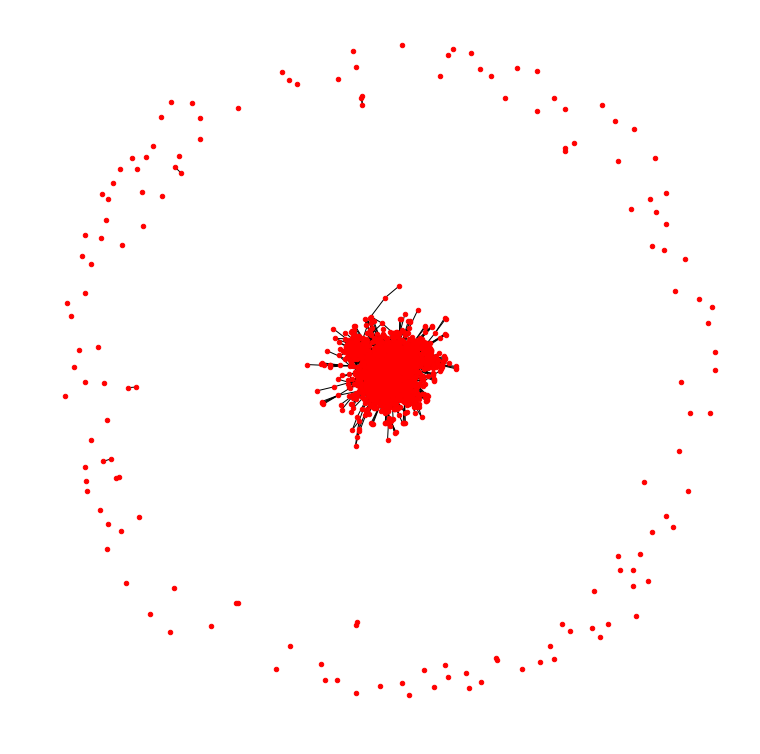

In [33]:
graph = nx.Graph(neighboursDictionary)

print 'Amount of Nodes:', len(graph.nodes())
print 'Amount of Edges:', len(graph.edges())

nx.draw(graph, node_size = 20)
plt.rcParams["figure.figsize"] = [10.0, 10.0]
plt.show()

### Friendship Paradox

> Does the song of ice and fire universe reflect the real world in terms of the Friendship Paradox?

In [13]:
def friendshipParadox(graph):
    boollist = []
    for node in graph.nodes():
        deg = nx.neighbors(graph, node)
        avg = 0.0
        for x in deg:
            avg += nx.degree(graph, x)
        if len(deg) > 0:
            avg /= len(deg)
        boollist += [avg >= nx.degree(graph, node)]

    return [boollist.count(True), boollist.count(False), len(boollist)]

In [14]:
data = friendshipParadox(graph)

print 'True count:', data[0], '=', 100.*data[0]/data[2], '%'
print 'False count:', data[1], '=', 100.*data[1]/data[2], '%'
print 'Total:', data[2]

del data

True count: 1951 = 95.4500978474 %
False count: 93 = 4.54990215264 %
Total: 2044


> It does hold true, and because of this, the book's universe mirrors reality.

### Centrality
> In order to find the 'main character(s)' we look at the centrality of the graph. We use multiple methods - navigation, degree, closeness, betweeness, eigenvektor, and google's pagerank - and find the best one from on overall score. The end result is a sorted list of the characters with the highest centrality.

In [15]:
def getPathDictionary(graph):
    # Counter
    i = 0
    max = len(graph.nodes())**2
    s = '%d / %d completed!' % (i,max)
    sys.stdout.write('%s\r' % s)
    sys.stdout.flush()
    
    # Find all source/target paths
    # {Source0: {Target0: [Source0, ... , Target0], ...}, ... }
    pathDictionary = defaultdict(lambda: dict())
    for name1 in graph.nodes():
        for name2 in graph.nodes():            
            # If path not already found
            if name2 not in pathDictionary[name1]:
                try:
                    path = nx.shortest_path(graph, name1, name2)
                except nx.NetworkXNoPath:
                    # No Path Found => Empty path
                    path = []
                    
                # Undirected Graph => reversed shortest path
                pathDictionary[name1][name2] = path
                pathDictionary[name2][name1] = path[::-1]
            
            # Counter
            i += 1
            s = '%d / %d completed!' % (i,max)
            sys.stdout.write('%s\r' % s)
            sys.stdout.flush()
        
    print '%d / %d completed!' % (max,max)
    return dict(pathDictionary)

In [16]:
pathDictionary = loadFile(Keys.pathDictionaryKey) # Will take some time
if not pathDictionary:
    pathDictionary = getPathDictionary(graph) # Will take ALOT of time
    saveFile(Keys.pathDictionaryKey, pathDictionary)

Data/pathDictionary.pkl loaded!


In [17]:
def getNavigationCentrality(pathDictionaty, characterSet):
    flatpaths = [e for paths in pathDictionary.values()
                     for path in paths.values()
                         for e in path[1:-1]] # Cut Source/Target
    counter = Counter(flatpaths)
    for name in characterSet:
        if name not in counter:
            counter[name] = 0
    count = [(name, float(score)/float(len(flatpaths)))
                 for name,score in counter.items()]
    return dict(count)

In [18]:
navCen = getNavigationCentrality(pathDictionary, characterSet)
degCen = nx.degree_centrality(graph)
cloCen = nx.closeness_centrality(graph)
betCen = nx.betweenness_centrality(graph)
eigCen = nx.eigenvector_centrality(graph)
pagCen = nx.pagerank(graph) # Google PageRank Centrality ~= Eigenvector

In [19]:
def getCentralityDictionary(dataNameSet, characterSet):
    centralityDictionary = dict()

    for name in characterSet:
        centralityDictionary[name] = dict()
        for data,n in dataNameSet:
            centralityDictionary[name][n] = data[name]
    
    return centralityDictionary

In [20]:
centralityDictionary = loadFile(Keys.centralityDictionaryKey)
if not centralityDictionary:
    centralityDictionary = getCentralityDictionary(
        [(navCen, 'nav'), (degCen, 'deg'), (cloCen, 'clo'), (betCen, 'bet'), (eigCen, 'eig'), (pagCen, 'pag')],
        characterSet )
    saveFile(Keys.centralityDictionaryKey, centralityDictionary)

Data/centralityDictionary.pkl loaded!


In [21]:
def getTopCentrality(dataSet, centralityDictionary, k=10):
    cen = []
    for data in dataSet:
        cen += [sorted(data.items(), key=lambda x: x[1], reverse=True)]

    scoreDict = defaultdict(lambda: 0)
    for i in xrange(len(characterSet)):
        for c in cen:
            scoreDict[c[i][0]] += i

    sortedDict = sorted(scoreDict.items(), key=lambda x: x[1])
    return [(e, centralityDictionary[e]) for e,_ in sortedDict][0:k]

In [22]:
topCentrality = getTopCentrality([navCen, degCen, cloCen, betCen, eigCen, pagCen], centralityDictionary, 10)

print 'Top Centrality:'
print '-'*max([len(x[0])+4 for x in topCentrality])
i = 0
for name,cents in topCentrality:
    print '{:2}.'.format(i+1), name
    print ''.join(['   %s: %f   '%(k,round(v,4)) for k,v in cents.items()])
    print ''
    i += 1

Top Centrality:
----------------------
 1. Jaime Lannister
   clo: 0.429200      nav: 0.043200      eig: 0.207300      pag: 0.010200      bet: 0.077600      deg: 0.128700   

 2. Stannis Baratheon
   clo: 0.434200      nav: 0.028900      eig: 0.181000      pag: 0.009100      bet: 0.077800      deg: 0.112100   

 3. Tyrion Lannister
   clo: 0.428200      nav: 0.023400      eig: 0.194600      pag: 0.009300      bet: 0.065400      deg: 0.116500   

 4. Tywin Lannister
   clo: 0.419500      nav: 0.019600      eig: 0.187800      pag: 0.007300      bet: 0.042900      deg: 0.095000   

 5. Robb Stark
   clo: 0.419200      nav: 0.022100      eig: 0.160300      pag: 0.007200      bet: 0.054300      deg: 0.093500   

 6. Cersei Lannister
   clo: 0.424100      nav: 0.016000      eig: 0.179500      pag: 0.006900      bet: 0.044800      deg: 0.093000   

 7. Arya Stark
   clo: 0.397600      nav: 0.021700      eig: 0.148400      pag: 0.008500      bet: 0.055000      deg: 0.097900   

 8. Robert I Ba

> If our hypothesis of the person with the highest centrality is the main character, Jaime lannister surely is the center of the plot - (which according to many fan-theories actually holds true). It makes sence that Jaime would the the node with the highest centrality, since he is litteraly all over the place in the story.

> The top 10 displayed hold pretty true in terms of multiple main characters. And while Daenerys Targryen is missing, it also makes sence, since her plot line has not yet intersected with the plot line of the rest of cast.

### Communities

> We're interested in seeing how well the great houses of Westeroes are doing as communities in the graph. We'll do this in 2 ways. The first is using a subgraph including all reachable nodes from the character with the highest centrality. - which means alot of communities with just a single node will be deleted. The second way is by using a subgraph containing only the characters mentioned in the list of great houses, this is done to if it affects the communities.

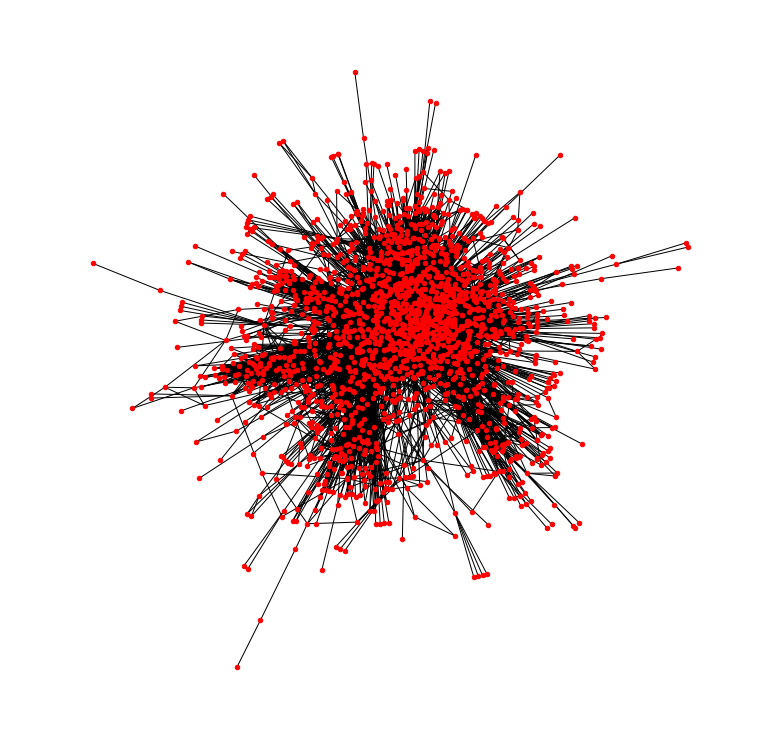

In [23]:
# Extracting subgraph from main graph,
# due to alot of nodes having no neighbours
# or being secluded graphs in pairs of 2

sub = [e for path in pathDictionary[topCentrality[0][0]].values() for e in path]
subGraph = nx.subgraph(graph, sub+[topCentrality[0][0]])

del sub

nx.draw_spring(subGraph, node_size = 20)
plt.rcParams["figure.figsize"] = [10.0, 10.0]
plt.show()

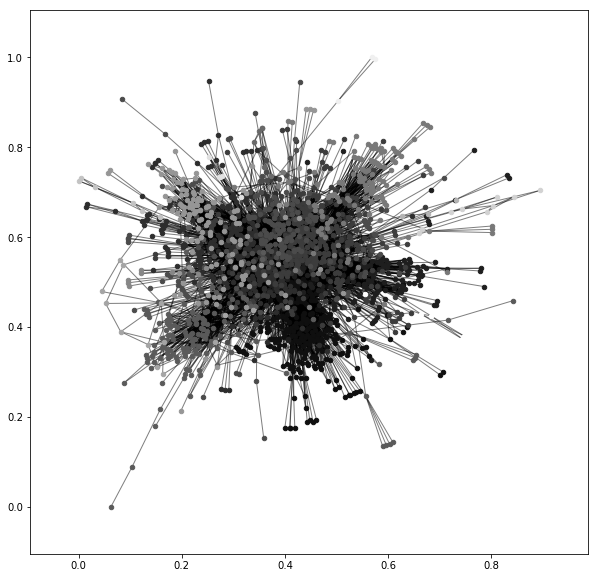

In [24]:
partition = community.best_partition(subGraph)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(subGraph)
count = 0.
for com in set(partition.values()):
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(subGraph, pos, list_nodes, node_size = 20, node_color = str(count / size))

nx.draw_networkx_edges(subGraph, pos, alpha=0.5)
plt.rcParams["figure.figsize"] = [10.0, 10.0]
plt.show()

In [25]:
reversePartition = defaultdict(lambda: [])
for name,index in partition.items():
    reversePartition[index] += [name]

### Confusion Matrx for subgraph of reachable nodes from top centrality character's node

In [26]:
def printMatrix(data, percent=False, i=11):
    a = zip(*data[::-1])
    print ''.join([('{:>%d}'%11).format(name) for name in greatHousesDictionary.keys()])
    print '-' * 11 * len(greatHousesDictionary.keys()[::-1])
    if not percent:
        print '\n'.join([''.join([('{:>%d}'%11).format(item if item!=0 else '-') for item in row]) for row in a])
    else:
        print '\n'.join([''.join([('{:>%d}'%11).format(str(item)+' %' if item!=0.0 else '-') for item in row]) for row in a])

In [27]:
mflat = []
mperc = []
for k,v in greatHousesDictionary.items():
    fc = [0]*len(reversePartition)
    for name in v:
        if name in partition:
            fc[partition[name]] += 1    
    mflat += [fc]
    mperc += [[int(1000.*f/len(v))/10. for f in fc]]

In [28]:
printMatrix(mflat)

  Targaryen     Bolton  Baratheon    Martell  Lannister       Frey      Stark    Greyjoy     Tyrell
---------------------------------------------------------------------------------------------------
          1          -          6          -          -          -          4          -          -
         41          -          2         10          -          -          6          -          -
          -         15          -          -          8         94         30          4          -
          1          -         10         40         15          3          6          -         28
          -          3          -          -          6          4         10          -          -
         14          -          -          -         12          3          1          -          7
          -          -          -          -          4          -          -          -          -
          -          -          -          -          -          -          1         17          -


In [29]:
printMatrix(mperc, True)

  Targaryen     Bolton  Baratheon    Martell  Lannister       Frey      Stark    Greyjoy     Tyrell
---------------------------------------------------------------------------------------------------
      1.0 %          -     31.5 %          -          -          -      4.7 %          -          -
     41.4 %          -     10.5 %     20.0 %          -          -      7.0 %          -          -
          -     83.3 %          -          -     15.6 %     80.3 %     35.2 %     18.1 %          -
      1.0 %          -     52.6 %     80.0 %     29.4 %      2.5 %      7.0 %          -     54.9 %
          -     16.6 %          -          -     11.7 %      3.4 %     11.7 %          -          -
     14.1 %          -          -          -     23.5 %      2.5 %      1.1 %          -     13.7 %
          -          -          -          -      7.8 %          -          -          -          -
          -          -          -          -          -          -      1.1 %     77.2 %          -


> Houses Martell, Greyjoy, Frey and Bolton which usually sticks to the same areas are not suprisingly sort of good communities. While the starks and targaryen are often split all over the place, which is also shown by the matrix values.

> While some houses are great communities others are not, which makes sence according to the story.

### Confusion Matrix for subgraph containg only characters from the Great Houses

In [30]:
# Sub graph of all greathouses
sub_ = [name for names in greatHousesDictionary.values() for name in names]
subGraph_ = nx.subgraph(graph, sub_)

# Sub Sub graph of all reachable nodes
sub_ = [n for n in subGraph_.nodes() if len(subGraph_.neighbors(n)) > 0]
subGraph_ = nx.subgraph(graph, sub_)
del sub_

# Partitioning
partition_ = community.best_partition(subGraph_)
reversePartition_ = defaultdict(lambda: [])
for name,index in partition_.items():
    reversePartition_[index] += [name]   

# Matrix
mflat_ = []
mperc_ = []
for k,v in greatHousesDictionary.items():
    fc = [0]*len(reversePartition_)
    for name in v:
        if name in partition_:
            fc[partition_[name]] += 1    
    mflat_ += [fc]
    mperc_ += [[int(1000.*f/len(v))/10. for f in fc]]

In [31]:
printMatrix(mflat_)

  Targaryen     Bolton  Baratheon    Martell  Lannister       Frey      Stark    Greyjoy     Tyrell
---------------------------------------------------------------------------------------------------
          3          -         12         40         17          -          3          -         28
          -         16          3          -          1         12         49          3          -
         44          -          3         10          1          -          -          -          -
          -          2          -          -         21         83          3          -          -
          -          -          -          -          -          -          9         18          -
         51          -          1          -          3          3          5          1          3
          -          -          -          -          -          7          -          -          -
          -          -          -          -          4          -          -          -          -


In [32]:
printMatrix(mperc_, True)

  Targaryen     Bolton  Baratheon    Martell  Lannister       Frey      Stark    Greyjoy     Tyrell
---------------------------------------------------------------------------------------------------
      3.0 %          -     63.1 %     80.0 %     33.3 %          -      3.5 %          -     54.9 %
          -     88.8 %     15.7 %          -      1.9 %     10.2 %     57.6 %     13.6 %          -
     44.4 %          -     15.7 %     20.0 %      1.9 %          -          -          -          -
          -     11.1 %          -          -     41.1 %     70.9 %      3.5 %          -          -
          -          -          -          -          -          -     10.5 %     81.8 %          -
     51.5 %          -      5.2 %          -      5.8 %      2.5 %      5.8 %      4.5 %      5.8 %
          -          -          -          -          -      5.9 %          -          -          -
          -          -          -          -      7.8 %          -          -          -          -


> Again Martell, Frey, Greyjoy and Bolton shows signs of being great communities, while the other houses are again split between many partitions. We have shown which communities are the strongest using the confusion matrices. 

> Taking the size of the houses into accord, one could say, that the Frey's are the best community, since they still stick together even with their great numbers.

# Sentiment functions

In order to analyze the sentiment of the transcripts, we set up a two helper functions, and loaded the sentimentTable.txt file.

The sentimentTable.txt file holds a large amount of words, and a rating from 1-10, where 10 is being the most happy and 1 would be the least.

The first helper function, calcSentiment, takes a wordlist and returns the general sentiment of this, using the sentimentTable's scores. One should note however, that if a word is not in the sentimentTable, it's given the value of 5. Neutral.

In [4]:
sentimentDict = dict()

with open("sentimentTable.txt", "r") as ins:
    array = []
    for line in ins:
        data = re.split(r'\t+', line)
        if not len(data) < 7:
            sentimentDict[data[0]] = data[2]

def calcSentiment(wordlist):
    sentimentScore = 0.0
    for word in wordlist:
        if (sentimentDict.get(word) is not None):
            sentimentScore += float(sentimentDict.get(word))
        else:
            sentimentScore += 5
    sentimentScore = sentimentScore/len(wordlist)
    if sentimentScore == 0:
        print("There's no words in the selection, or the words does not carry any information about sentiment.")
    elif sentimentScore < 3.5:
        print("The tokens are sad, with a score of: " + str(sentimentScore))
    elif sentimentScore < 7:
        print("The tokens are neutral, with a score of: " + str(sentimentScore))
    else:
        print("The tokens are happy, with a score of: " + str(sentimentScore))

Finally the last helper function sentimentProfile, also takes a wordlist and windows size. This function uses the prior function to create a graph of sentiment, over a large text. The function takes the amount of words in the window size, and passes these to the calcSent function. By doing this for the entire text, a lot of data points is found and thus a graph can be made.

In [5]:
def sentimentProfile(wordList, windowsSize):
    windowsSentimentScore = 0.0
    windowSentimentArray = list()
    for i in range(1, len(wordList)+1):
        if not windowsSize == 1:
            if not i % windowsSize == 0.0:
                if sentimentDict.get(wordList[i-1]) != None:
                    windowsSentimentScore += float(sentimentDict.get(wordList[i-1]))
                else:
                    windowsSentimentScore += 5
                if i == len(wordList):
                    windowsSentimentScore = windowsSentimentScore / float(windowsSize)
                    windowSentimentArray.append(windowsSentimentScore)
            else:
                windowsSentimentScore = windowsSentimentScore/float(windowsSize)
                windowSentimentArray.append(windowsSentimentScore)
                windowsSentimentScore = 0.0
        else:
            if sentimentDict.get(wordList[i-1]) != None:
                    windowSentimentArray.append(float(sentimentDict.get(wordList[i-1])))
            else:
                windowSentimentArray.append(5.0)
            
    plt.plot(range(0,len(wordList),windowsSize),windowSentimentArray)
    plt.show()
    return windowSentimentArray

# Transcript data loading

The priorly mentioned transcripts was downloaded as .srt files and loaded in using the pysrt library.
Finally the transcripts were accumulated into the seaosons of the show.

In [6]:
#Get the combined transcripts for all seasons, for further sentiment analysis.
seasons = []
folders = glob.glob("transcripts/*")
folders.sort()
for folder in folders:
    transcripts = glob.glob(folder + "/*")
    season = ""
    transcripts.sort()
    for transcript in transcripts:
        #print(transcript)
        subs = pysrt.open(transcript, encoding='iso-8859-1')
        for subt in subs:
            season += re.sub('\W+',' ',subt.text.lower())
    seasons.append(season)

# Sentiment & similarity analysis

To be able to answer the questions we've asked ourselves regarding the greatness of the great houses, we used the similar function of the nltk library, to get the words similar to the house names for each of the priorly stated 9 great houses. These are then saved in files to be used later. (This wasn't as much a choice, as a neccessity, as the nltk function similar only print's the similar words, it doesn't return them.)

Along with this we - once again - used the nltk library to create a lexical dispersion plot, over the usage of the different houses, to see which are the most prominent in each season.

At last we use the sentimentProfile helper function to get the general sentiment of each season.

Season: 1


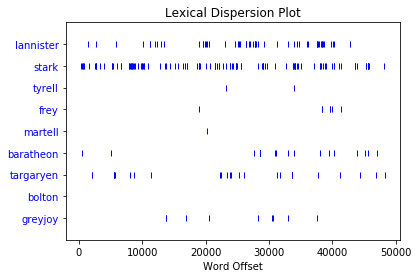

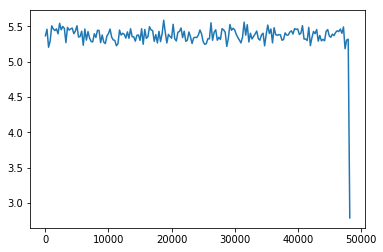

Season: 2


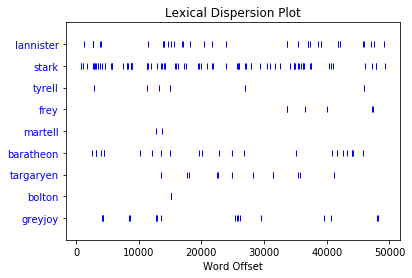

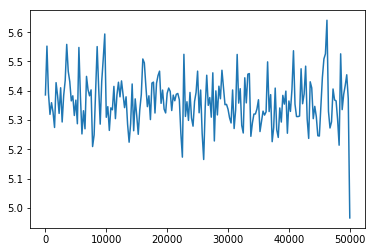

Season: 3


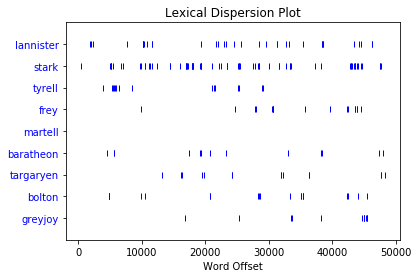

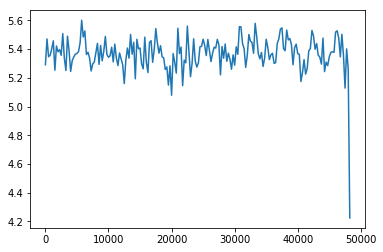

Season: 4


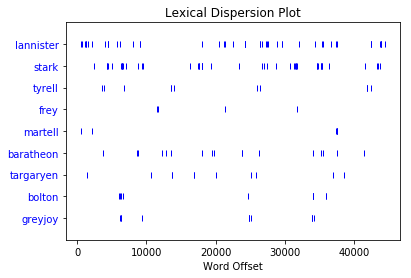

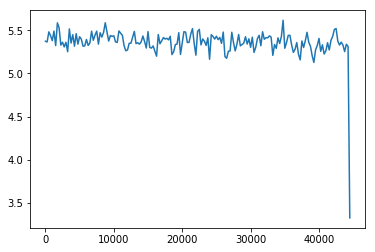

Season: 5


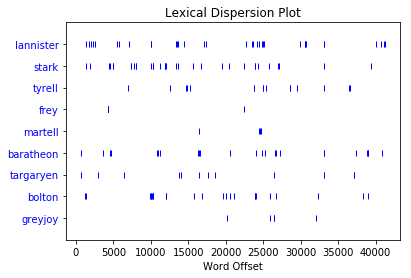

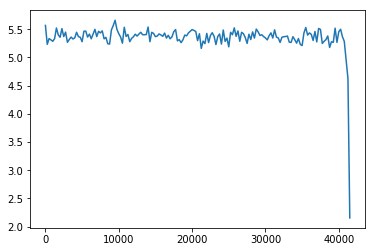

Season: 6


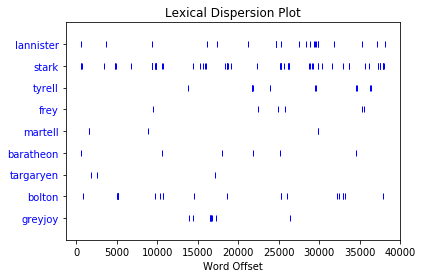

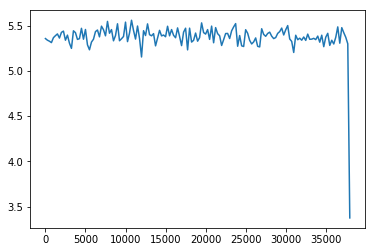

Season: 7


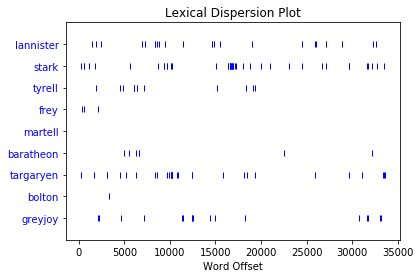

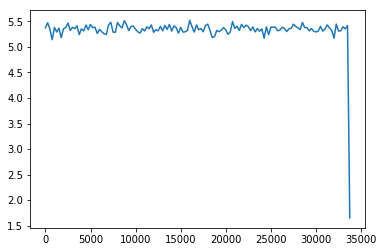

In [7]:
complete = ""
for season in seasons:
    complete += season
    tokens = nltk.word_tokenize(season)
    print("Season: " + str((seasons.index(season)+1)))
    text = nltk.Text(tokens)
    text.dispersion_plot(["lannister","stark","tyrell","frey","martell","baratheon","targaryen","bolton","greyjoy"])
    temp = sys.stdout                 # store original stdout object for later
    sys.stdout = open('sentiments/lannister' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("lannister")
    sys.stdout.close()                # ordinary file object
    sys.stdout = open('sentiments/stark' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("stark")
    sys.stdout.close()
    sys.stdout = open('sentiments/tyrell' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("tyrell")
    sys.stdout.close()
    sys.stdout = open('sentiments/frey' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("frey")
    sys.stdout.close()
    sys.stdout = open('sentiments/martell' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("martell")
    sys.stdout.close()
    sys.stdout = open('sentiments/baratheon' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("baratheon")
    sys.stdout.close()
    sys.stdout = open('sentiments/targaryen' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("targaryen")
    sys.stdout.close()
    sys.stdout = open('sentiments/bolton' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("bolton")
    sys.stdout.close()
    sys.stdout = open('sentiments/greyjoy' + str((seasons.index(season)+1)) + '.txt', 'w') # redirect all prints to this log file
    text.similar("greyjoy")
    sys.stdout.close()
    sys.stdout = temp 
    seasonList = season.encode('utf-8').split()
    sentProfile = sentimentProfile(seasonList, 250)


**Season 1**

    The season is dominated by the Lannisters and the Starks with only minor mentions of the Baratheons and the Targaryens. It should also be noted that the Boltons is not at all mentioned, and the Tyrells and the Martells are only mentioned a few times each.
    
    Sentiment-wise the season is quite stable, with a score between 5.25 and 5.5, without too much variation.

**Season 2**

    The second season follows the first in regard to the Lannisters and the Starks. In this season however, all of the 9 great houses are mentioned at least once.
    
    Sentiment-wise the second season has a tiny bit more variation, which can be seen as the graph swings between 5.2 and 5.6. Although this isn't 

**Season 3**

    The theme with the Starks and Lannisters continues, and the Martells are once again not mentioned. On the other hand, the rest of the houses (save for Stark and Lannister) is metioned a rather equal amount of times.
    
    Sentiment-wise this season seems to have darker times compared to the two prior seasons. This can be seen as there are times where the graph dips below 5.2 although it also reaches up towards 5.6 .

**Season 4**

    For the second time all of the houses are mentioned in a season, and although still dominating, the Lannisters and the Starks aren't mentioned anywhere near as much as they were in the previous seasons.
    
    This is the most sentiment-wise compact season yet, being tightly concentrated around 5.5.

**Season 5**

    The general theme of the last season continues, with sparser mentions of the Lannisters and the Starks, and all great houses being mentioned.
    
    Like the last season the sentiment has very little variation, however this time it's tightly bound just below 5.5 .
    
**Season 6**

    An element to be noticed this time around, is the Boltons being quite prominent with a lot of mentions alongside the the Starks and Lannisters. Otherwise the theme carries through.
    
    This season operates in roughly the same span as the prior, but with greater general variance throughout the season.

**Season 7**

    For the final season, the Lannisters and the Starks are still the most prominent, however more sparse than priorly. In this season the Martells however aren't metioned at all, and the Boltons are mentioned only once. This is to be expected with the extinction of the houses. A final thing to note is the rise of the Targaryens, rivalling the Lannisters in amount of mentions.
    
    The final season seems to follow the last, however going a bit lower sentiment-wise.

**General tendencies**

    Throughout all of the season the lexical dispersion plots show a bias towards the Lannisters and the Starks, as these by far are the most talked-about great houses.
    Only in the final season does the two houses get challenged by house Targaryen.
    
    As for the sentiment mapping, the sentiment score is seemingly always above 5, and thus always on the happier side.
    It should be noted however, that this maybe due to the choice of letting unknown words pass as neutral (a score of 5).
    Finally one might argue that the sentiment is VERY stable, with variations in the range of 0.1's rather than larger numbers, but this is to be expected, when each datapoint is an average of 250 words.


# Great house sentiment analysis

To analyse the sentiment of the houses, we concatenate all the outputs from the nltk similar function, for all of the houses. This data is then analysed using the calcSent helper function from earlier.

In [8]:
lannisterSent = glob.glob("sentiments/lannister*")
starkSent = glob.glob("sentiments/stark*")
tyrellSent = glob.glob("sentiments/tyrell*")
freySent = glob.glob("sentiments/frey*")
martellSent = glob.glob("sentiments/martell*")
baratheonSent = glob.glob("sentiments/baratheon*")
tagaryenSent = glob.glob("sentiments/targaryen*")
boltonSent = glob.glob("sentiments/bolton*")
greyjoySent = glob.glob("sentiments/greyjoy*")

houses = []
houses.append(lannisterSent)
houses.append(starkSent)
houses.append(tyrellSent)
houses.append(freySent)
houses.append(martellSent)
houses.append(baratheonSent)
houses.append(tagaryenSent)
houses.append(boltonSent)
houses.append(greyjoySent)

combinedSents = []

for house in houses:
    combinedsent = ""
    for sent in house:
        file = open(sent, "r")
        combinedsent += file.read()
    combinedSents.append(combinedsent)

for sents in combinedSents:
    calcSentiment(sents.split())



The tokens are neutral, with a score of: 5.51795454545
The tokens are neutral, with a score of: 5.28213235294
The tokens are neutral, with a score of: 5.30170212766
The tokens are neutral, with a score of: 5.15266666667
The tokens are neutral, with a score of: 5.42814814815
The tokens are neutral, with a score of: 5.27575
The tokens are neutral, with a score of: 5.2376
The tokens are neutral, with a score of: 5.42305882353
The tokens are neutral, with a score of: 5.28638297872


All of the outputs are seemingly neutral, however some conclusions can still be drawn from the data:
1. The house spoken most highly about is the Lannisters
2. The most disliked house is the Freys

Both of these are to be expected, as the Lannisters are the de facto ruling house in Westeros, and generally speak extremely highly of themselves. Finally the Freys are expected to be disliked due to their revolting actions at the red wedding.

# Top ten character sentiment analysis

Our final point of analysis is to look at the top 10 characters as found in the network analysis.

The general idea is the same as with the house analysis, taking the same steps.

In [10]:
topTenChars = []
topTenChars.append("jaime")
topTenChars.append("stannis")
topTenChars.append("tyrion")
topTenChars.append("tywin")
topTenChars.append("robb")
topTenChars.append("cersei")
topTenChars.append("arya")
topTenChars.append("robert")
topTenChars.append("jon")
topTenChars.append("joffrey")

tokens = nltk.word_tokenize(complete)
text = nltk.Text(tokens)

for char in topTenChars:
    temp = sys.stdout                 
    sys.stdout = open('sentiments/' + char + '.txt', 'w') 
    text.similar(char)
    sys.stdout.close()
    sys.stdout = temp 
    
for char in topTenChars:
    charFile = glob.glob("sentiments/" + char +"*")
    file = open(charFile[0], "r")
    print(char + ": ")
    calcSentiment(file.read().split())



jaime: 
The tokens are neutral, with a score of: 5.122
stannis: 
The tokens are neutral, with a score of: 5.452
tyrion: 
The tokens are neutral, with a score of: 5.381
tywin: 
The tokens are neutral, with a score of: 5.299
robb: 
The tokens are neutral, with a score of: 5.411
cersei: 
The tokens are neutral, with a score of: 5.265
arya: 
The tokens are neutral, with a score of: 5.476
robert: 
The tokens are neutral, with a score of: 5.398
jon: 
The tokens are neutral, with a score of: 5.522
joffrey: 
The tokens are neutral, with a score of: 5.486


After analyzing the top ten characters found in the network analysis, we can draw a few conclusions:

1. The most well liked person is Jon Snow
2. The least liked character is Jaime Lannister
3. Jon Snow is followed by Arya Stark, Joffrey Baratheon, Stannis Baratheon and Robb Stark.

One could argue that there's something odd at play, when Joffrey seems to be so liked. However when one considers how greatly he's spoken of by his family and those afraid of him, it's not that odd at all.

Another point of interest is the fact that Jaime Lannister is the most disliked of the top ten characters. Although Jaime generally appear compassinate specially after the loss of his hand, he's still referrede to by many as the Kingslayer or the Kinslayer. This may end up being the reason he's associated with the least happy words.

# What went well?

We were able to succesfully create a social network containing all the characters from Game of Thrones. On that network we have extracted communities and centrality values. 
From those values we were able to determine who the 10 most important persons in the series is, and then use that to perform sentiment analysis on them.
In the NLTK part of the project we were able to download and process the transcripts for all the seasons. We then succesfully created a lexial dispersion plot for all the seasons showing the mentions of the great houses.
We also used the names of the great houses to see which words most often are associated with the different great houses.
By testing the friendship paradox on the created network, we found that it actually produces the same result as a real world network would do. It can therefore be concluded that the world created by G. R. R. Martin is close to the real
world in terms of relations between people.

# What is still missing?

We were unable to find a complete list of the characters from the tv-shows. Therefore there is no comparison between the main characters of the book versus thee main character of the tv-show.
By looking at the network it was discovered that the "List of Characters" from the wiki, did not contain every person in the universe, since they were mentioned on other pages. 
We do speculate that it will not have an influence on the network graph, since minor characters like those, probably won't have more that 1-2 edges, and thus will be on the edge of the graph.

For doing the sentiment analysis of the different houses, use of the books might have been better. Books often describe persons using more words with a positive or negative sentiment value, where the tv shows describes the 
persons using their actions. Since we did not have access to the entire books in a pdf format, we could not use the books for sentiment analysis. It is also not the best solution to mix the characters of the books
with the transcripts of the tv shows, because some characters are not in the tv show.